<a href="https://colab.research.google.com/github/bielperello/Node21_AA_2025-26/blob/modelsClas2/Node21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projecte Node21: Classificació i Detecció de Nòduls Pulmonars en Radiografies de Pit.

## Introducció
En aquest projecte abordarem la detecció de nòduls pulmonars en radiografies de tòrax (CXR) seguint l'enunciat del repte **Node21** ([enllaç al repte](https://node21.grand-challenge.org/)). El repte Node21 proporciona un conjunt de dades públic de radiografies frontals de pit amb nòduls pulmonars anotats mitjançant **caixes delimitadores** (bounding boxes). En total consta d'aproximadament **4.882 radiografies**, de les quals **1.134** contenen almenys un nòdul i **3.748** imatges no en contenen, actuant com a casos negatius.  

L'objectiu consisteix en aplicar tècniques d'aprenentatge automàtic al problema proposat. S'han definit un **conjunt de tasques seqüencials** per tal de facilitar-ne el desenvolupament:

1. **Classificació**: Desenvolupar un sistema de classificació binària capaç de determinar si una radiografia conté nòduls pulmonars. Aquesta tasca es resoldrà mitjançant l'avaluació de **quatre models diferents**, alguns d'entrenats des de zero i d'altres aprofitant tècniques de *transfer learning*.
2. **Detecció**: Implementar models de detecció per localitzar els nòduls en la imatge, identificant-ne la posició amb caixes delimitadores. Per aquesta tasca es faran servir **dues arquitectures diferents** basades en *deep learning*.
3. **Innovació**: S’obre la possibilitat d’aplicar tècniques avançades o enfocaments propis que ampliïn o millorin les metodologies aplicades.

Per abordar aquestes tasques, utilitzarem un únic *notebook* Jupyter que integrarà tot el codi i explicacions necessàries. S'empraran diverses tècniques i models d'**aprenentatge automàtic** i **aprenentatge profund** vists a classe.


## Preparació de l'entorn i dependències
Abans de començar, assegurem-nos de tenir instal·lades totes les **dependències** necessàries. El projecte requerirà les biblioteqües següents:

- **NumPy** - per a manipulació de dades numèriques i de taules (anotacions).
- **PyTorch** - per construir i entrenar els models de CNN i Transfer Learning.
- **Matplotlib** - per a la visualizació de gràfiques i imatges.

Podem instal·lar els paquets que falten directament des del notebool. Per exemple:

`pip install torch torchvision scikit-learn matplotlib numpy`

També assegurarem una estructura de carpetes correcta en el directori de treball actual:

- `data/` - Contindrà les dades del NODE21 (imatges i anotacions).
- `utils/` - Codi de suport reutilitzable, com ara funcions d’augmentació, classes Dataset, funcions per dibuixar caixes, etc.
- `outputs/` - Elements de sortida.


## Obtenció i preparació de les dades Node21

Per dur a terme les tasques de classificació i detecció de nòduls pulmonars, utilitzarem les dades proporcionades pel repte NODE21, descarregades des del repositori oficial de Zenodo. Aquest conjunt inclou radiografies de tòrax simulades amb nòduls inserits artificialment i anotacions detallades sobre la seva posició.

A causa de la mida del conjunt complet (~35 GB), no resulta eficient entrenar directament amb totes les imatges en un entorn personal. Per això, optarem per treballar amb un subconjunt configurable del total d’imatges, mantinguent una distribució equilibrada entre imatges positives (amb nòduls) i negatives (sense nòduls), que és fonamental per garantir una bona generalització del model.

Les imatges es troben dins la carpeta:

`data/cxr_images/proccessed_data/images/`

i tenen format **.mha**. Les anotacions associades es troben al fitxer

`data/cxr_images/proccessed_data/metadata.csv`

Aquest fitxer indica, per a cada imatge, el seu nom, l'etiqueta (label per diferenciar si hi ha nòdul o no) i les coordenades **(x, y, width, height)** corresponents, en cas de no haver nòdul (label 0) el valors són de 0. Aquest enfocament ens permet construir tant:

- **Etiquetes binàries** per a classificació: 1 si hi ha algun nòdul, 0 si no.
- **Bounding boxes per detecció**: una o més caixes per imatge, o cap.

In [165]:
import os
import sys
import torch
import pandas as pd
import SimpleITK as sitk
import numpy as np
import cv2
import matplotlib.pyplot as plt
import Node21_Utils as Utils
import Node21_Models as Models

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split


# Ruta a les imatges i anotacions
IMG_DIR = "data/cxr_images/proccessed_data/images"
ANNOTATION_FILE = "./data/cxr_images/proccessed_data/metadata.csv"

# Nombre total d'imatges a utilitzar (ajustable)
N_IMAGES = 2000  # Exemple: 500 imatges en total (positives + negatives)
VAL_RATIO = 0.25  # 25% per a validació

# Mida d'entrada desitjada per al model
IMG_SIZE = 512
# Mida del batch
BATCH_SIZE = 32
'''
# Per dur a terme proves al colab, canviem la ruta on hem afegit el zip amb el dataset reduït i realitzem un parell de canvis
IMG_DIR = "/content/dataset_reduit/images"
ANNOTATION_FILE = "/content/dataset_reduit/metadata.csv"

sys.path.append("/content/drive/MyDrive/Projecte_Node21")

N_IMAGES = len(os.listdir(IMG_DIR))
VAL_RATIO = 0.25
IMG_SIZE = 512
BATCH_SIZE = 32
'''

'\n# Per dur a terme proves al colab, canviem la ruta on hem afegit el zip amb el dataset reduït i realitzem un parell de canvis\nIMG_DIR = "/content/dataset_reduit/images"\nANNOTATION_FILE = "/content/dataset_reduit/metadata.csv"\n\nsys.path.append("/content/drive/MyDrive/Projecte_Node21")\n\nN_IMAGES = len(os.listdir(IMG_DIR))\nVAL_RATIO = 0.25\nIMG_SIZE = 512\nBATCH_SIZE = 32\n'

In [166]:
import pandas as pd
import os

 # Carregam el CSV d'anotacions
df = pd.read_csv(ANNOTATION_FILE)

annotations_dict = {}
labels_dict = {}

for _, row in df.iterrows():
    img_id = str(row['img_name']).replace('.mha', '')  # treim extensió
    label = int(row["label"])

    # Guardam la label (si hi ha múltiples files per la mateixa imatge, max() manté 1 si hi ha qualque nòdul)
    if img_id in labels_dict:
        labels_dict[img_id] = max(labels_dict[img_id], label)
    else:
        labels_dict[img_id] = label

    # Guardam caixes només si és positiva i la caixa és vàlida
    if label == 1 and float(row["width"]) > 0 and float(row["height"]) > 0:
        box = [float(row["x"]), float(row["y"]), float(row["width"]), float(row["height"])]
        annotations_dict.setdefault(img_id, []).append(box)

# Asseguram que totes les imatges tenguin entrada a annotations_dict
for img_id in labels_dict.keys():
    annotations_dict.setdefault(img_id, [])

# Estadístiques
n_pos = sum(labels_dict[i] for i in labels_dict)
n_neg = len(labels_dict) - n_pos
print(f"Total imatges: {len(labels_dict)} | Positives: {n_pos} | Negatives: {n_neg}")

Total imatges: 4882 | Positives: 1134 | Negatives: 3748


In [167]:
# --- CODI ORIGINAL COMENTAT ---
img_ids = list(labels_dict.keys())
img_labels = [labels_dict[i] for i in img_ids]
if N_IMAGES > len(img_ids):
    N_IMAGES = len(img_ids)
_, subsampled_ids, _, _ = train_test_split(
     img_ids, img_labels, test_size=N_IMAGES, stratify=img_labels, random_state=42)
labels_subsampled = [labels_dict[i] for i in subsampled_ids]
X_train, X_val = train_test_split(subsampled_ids, test_size=VAL_RATIO, stratify=labels_subsampled, random_state=42)

print(f"Samples d'entrenament: {len(X_train)}")
print(f"Samples de validació: {len(X_val)}")

Samples d'entrenament: 1500
Samples de validació: 500


In [168]:
img_p = sitk.ReadImage("data/cxr_images/proccessed_data/images/c0875.mha")

arr_p = sitk.GetArrayFromImage(img_p)

print(f"Forma:  {arr_p.shape}")
print(f"Mínim: {arr_p.min()}")
print(f"Màxim: {arr_p.max()}")


Forma:  (1024, 1024)
Mínim: 0
Màxim: 4095


La imatge és **2D** (1024, 1024). El rang és fix i conegut **[0,4095]** (representació de 12 bits)

In [169]:
class CXRClassificationDataSet(Dataset):
    def __init__(self, img_ids, labels_dict, img_dir, img_size, transform=None):
        self.img_ids = img_ids
        self.labels_dict = labels_dict
        self.img_dir = img_dir
        self.img_size = img_size
        self.transform = transform

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        label = self.labels_dict[img_id]

        # Ruta de la imatge .mha
        path = os.path.join(self.img_dir, f"{img_id}.mha")
        img = sitk.ReadImage(path)
        arr = sitk.GetArrayFromImage(img)

        # Normalització per percentils (millora el contrast)
        p1, p99 = np.percentile(arr, (1, 99))
        arr = np.clip(arr, p1, p99)
        arr = ((arr - p1) / (p99 - p1)) * 255.0
        arr = arr.astype(np.uint8)

        # Redimensionar a img_size x img_size
        arr_resized = cv2.resize(arr, (self.img_size, self.img_size))

        # Convertir a tensor (1 canal, H, W) i normalitzar a [0,1]
        tensor = torch.from_numpy(arr_resized).float().unsqueeze(0) / 255

        if self.transform:
            tensor = self.transform(tensor)

        return tensor, torch.tensor(label, dtype=torch.float32)

In [170]:
from torchvision import transforms
# Defineix les transformacions per evitar Shortcut Learning
# Transformacions per a Train (Augment + Normalització)
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.Normalize(mean=[0.5], std=[0.5]) # Centrat estadístic per a 1 canal
])

# Transformacions per a Val (Només normalització)
val_transforms = transforms.Compose([
    transforms.Normalize(mean=[0.5], std=[0.5])
])

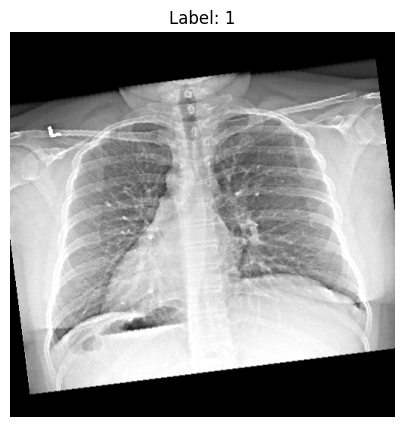

Tipus img: <class 'torch.Tensor'>
Shape img: torch.Size([1, 512, 512])
Min / Max img: -1.0 0.9039223194122314
Label: 1.0


In [171]:
train_dataset = CXRClassificationDataSet(
    img_ids=X_train,
    labels_dict=labels_dict,
    img_dir=IMG_DIR,
    img_size=512,
    transform=train_transforms 
)

# 170 label 1 / 194 label 0
img, label = train_dataset[170]

plt.figure(figsize=(5, 5))
plt.imshow(img.squeeze(0), cmap="gray")
plt.title(f"Label: {int(label.item())}")
plt.axis("off")
plt.show()

print("Tipus img:", type(img))
print("Shape img:", img.shape)
print("Min / Max img:", img.min().item(), img.max().item())
print("Label:", label.item())

val_dataset = CXRClassificationDataSet(
    img_ids=X_val,
    labels_dict=labels_dict,
    img_dir=IMG_DIR,
    img_size=512,
    transform=val_transforms    
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [172]:
import Node21_Utils as Utils
import Node21_Models as Models
import importlib

importlib.reload(Utils)
importlib.reload(Models)

<module 'Node21_Models' from 'C:\\Users\\pauan\\Documentos\\Universidad\\Quart\\1er Quatrimestre\\Aprenentatge Automàtic\\Node21_AA_2025-26\\Node21_Models.py'>

## Entrenament del Model 1: TinyCXRNet

cpu


Èpoques:  10%|█         | 1/10 [03:33<31:57, 213.02s/it]

[Època 1] Train loss 1.1166 acc 0.513 | Val loss 1.0385 acc 0.685


Èpoques:  20%|██        | 2/10 [06:06<23:44, 178.12s/it]

[Època 2] Train loss 1.0376 acc 0.585 | Val loss 1.0234 acc 0.564


Èpoques:  30%|███       | 3/10 [09:19<21:33, 184.84s/it]

[Època 3] Train loss 1.0159 acc 0.615 | Val loss 1.0104 acc 0.613


Èpoques:  40%|████      | 4/10 [16:16<27:39, 276.62s/it]

[Època 4] Train loss 0.9990 acc 0.636 | Val loss 0.9915 acc 0.749


Èpoques:  50%|█████     | 5/10 [23:03<26:57, 323.53s/it]

[Època 5] Train loss 0.9776 acc 0.654 | Val loss 0.9721 acc 0.699


Èpoques:  60%|██████    | 6/10 [29:51<23:28, 352.18s/it]

[Època 6] Train loss 0.9644 acc 0.655 | Val loss 0.9865 acc 0.771


Èpoques:  70%|███████   | 7/10 [35:37<17:30, 350.07s/it]

[Època 7] Train loss 0.9031 acc 0.706 | Val loss 0.8942 acc 0.766


Èpoques:  80%|████████  | 8/10 [38:11<09:35, 287.67s/it]

[Època 8] Train loss 0.8644 acc 0.716 | Val loss 0.8457 acc 0.782


Èpoques:  90%|█████████ | 9/10 [43:22<04:55, 295.12s/it]

[Època 9] Train loss 0.8203 acc 0.741 | Val loss 0.7475 acc 0.789


Èpoques: 100%|██████████| 10/10 [47:49<00:00, 286.91s/it]

[Època 10] Train loss 0.7074 acc 0.790 | Val loss 0.8067 acc 0.858


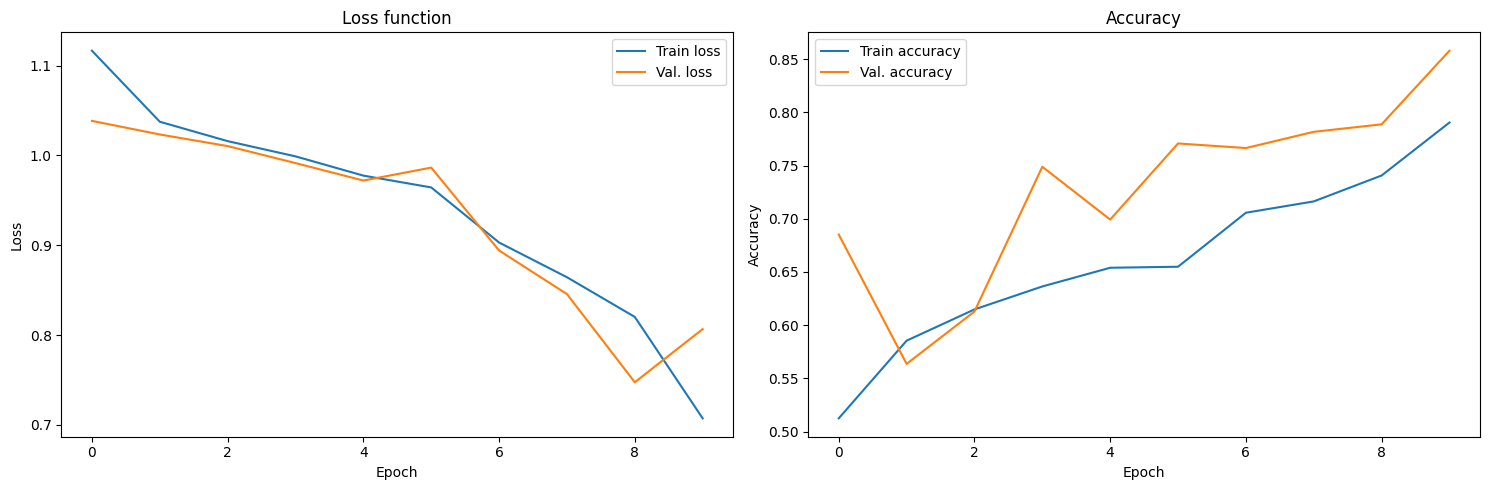

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = Models.TinyCXRNet().to(device)

pos_weight = Utils.compute_pos_weight(X_train, labels_dict, device=device)
loss_fn = Utils.make_loss(pos_weight)
optimizer = Utils.make_optimizer(model, lr=1e-4, weight_decay=1e-4)

history = Utils.fit(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=10,
    device=device,
)

Utils.plot_training_history(history=history)

## Entrenament del Model 2: ResNet18Binary

## Entrenament del Model 3: DenseNet121Binary

cpu
Entrenant Model 3: DenseNet121...


Èpoques:  20%|██        | 1/5 [16:38<1:06:34, 998.50s/it]

[Època 1] Train loss 1.0480 acc 0.564 | Val loss 1.0411 acc 0.268


Èpoques:  40%|████      | 2/5 [32:07<47:52, 957.62s/it]  

[Època 2] Train loss 0.9799 acc 0.696 | Val loss 0.9890 acc 0.425


Èpoques:  60%|██████    | 3/5 [47:48<31:39, 949.81s/it]

[Època 3] Train loss 0.8852 acc 0.748 | Val loss 0.8642 acc 0.721


Èpoques:  80%|████████  | 4/5 [1:03:16<15:41, 941.51s/it]

[Època 4] Train loss 0.7254 acc 0.807 | Val loss 0.6775 acc 0.804


Èpoques: 100%|██████████| 5/5 [1:18:52<00:00, 946.51s/it]

[Època 5] Train loss 0.5228 acc 0.890 | Val loss 0.4913 acc 0.929


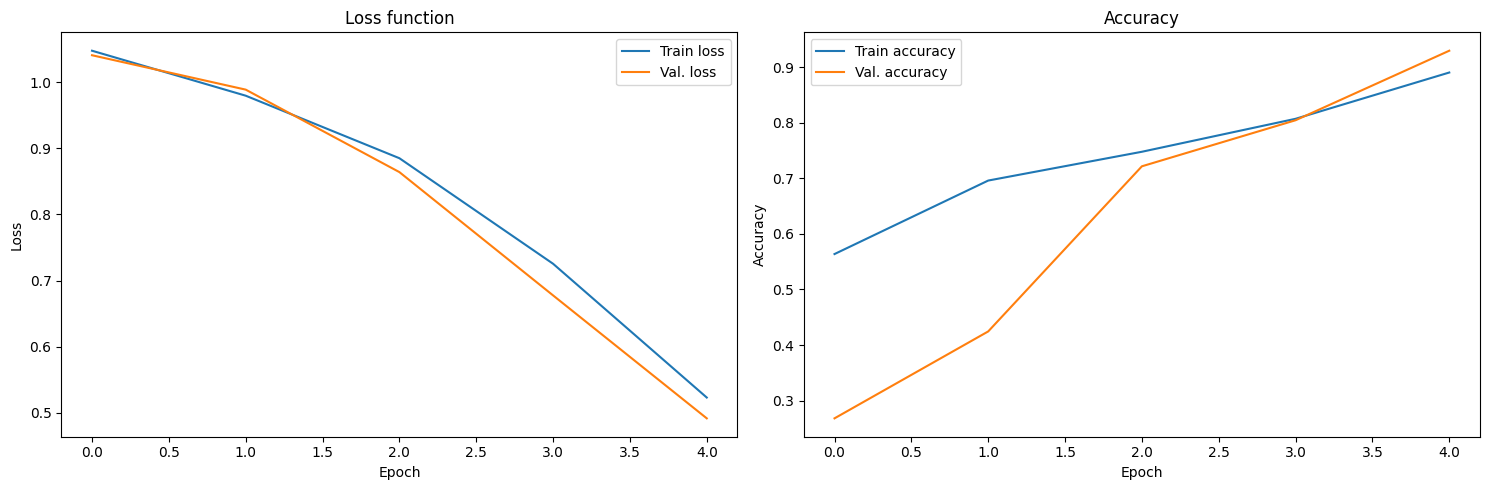

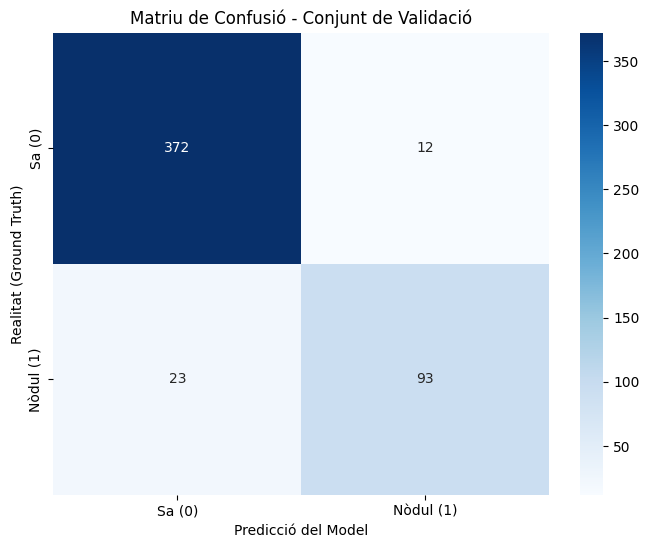


--- Informe de Classificació ---
              precision    recall  f1-score   support

          Sa       0.94      0.97      0.96       384
       Nòdul       0.89      0.80      0.84       116

    accuracy                           0.93       500
   macro avg       0.91      0.89      0.90       500
weighted avg       0.93      0.93      0.93       500



In [173]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model3 = Models.DenseNet121Binary().to(device)

pos_weight = Utils.compute_pos_weight(X_train, labels_dict, device=device)

loss_fn = Utils.make_loss(pos_weight)

optimizer3 = Utils.make_optimizer_denseNet(model3, lr=1e-5, weight_decay=1e-2)

# Entrenament
print("Entrenant Model 3: DenseNet121...")
history3 = Utils.fit(
    model=model3,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=loss_fn,
    optimizer=optimizer3,
    epochs=5,
    device=device,
)

Utils.plot_training_history(history=history3)
Utils.plot_confusion_matrix(model3, val_loader, device)

## Entrenament del Model 4: InceptionV3Binary

cpu


Èpoques:  20%|██        | 1/5 [12:37<50:29, 757.49s/it]

[Època 1] Train loss 1.0628 acc 0.549 | Val loss 1.0545 acc 0.766


Èpoques:  40%|████      | 2/5 [24:12<36:01, 720.48s/it]

[Època 2] Train loss 1.0528 acc 0.636 | Val loss 1.0372 acc 0.600


Èpoques:  60%|██████    | 3/5 [35:45<23:36, 708.28s/it]

[Època 3] Train loss 1.0245 acc 0.663 | Val loss 1.0153 acc 0.661


Èpoques:  80%|████████  | 4/5 [47:03<11:36, 696.25s/it]

[Època 4] Train loss 0.9893 acc 0.704 | Val loss 0.9753 acc 0.672


Èpoques: 100%|██████████| 5/5 [59:15<00:00, 711.17s/it]

[Època 5] Train loss 0.9199 acc 0.755 | Val loss 0.8948 acc 0.715


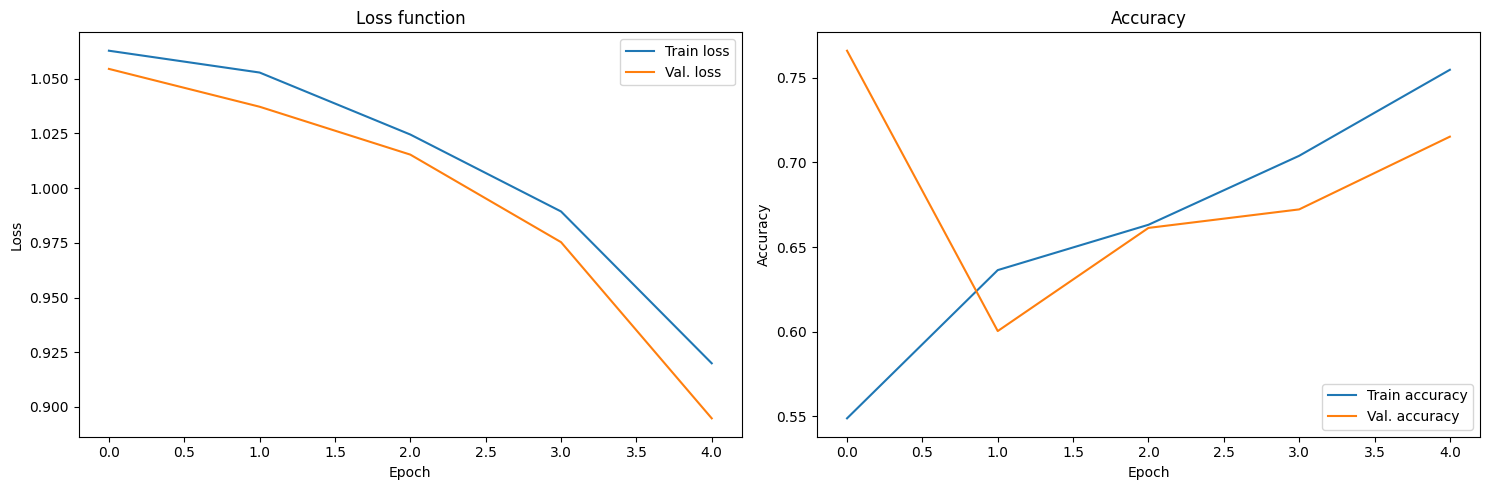

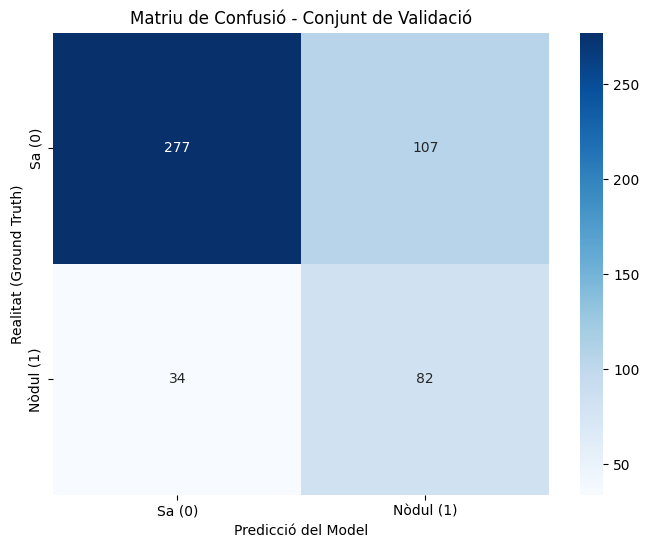


--- Informe de Classificació ---
              precision    recall  f1-score   support

          Sa       0.89      0.72      0.80       384
       Nòdul       0.43      0.71      0.54       116

    accuracy                           0.72       500
   macro avg       0.66      0.71      0.67       500
weighted avg       0.78      0.72      0.74       500



In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model4 = Models.InceptionV3Binary().to(device)

pos_weight = Utils.compute_pos_weight(X_train, labels_dict, device=device)

loss_fn = Utils.make_loss(pos_weight)

optimizer4 = Utils.make_optimizer(model4, lr=1e-5, weight_decay=5e-2)

# Entrenament
history4 = Utils.fit(
    model=model4,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=loss_fn,
    optimizer=optimizer4,
    epochs=5,
    device=device
)

Utils.plot_training_history(history4)
Utils.plot_confusion_matrix(model4, val_loader, device)

## Classificació

### Model 1

#### Capes de `TinyCXRNet` per a classificació binària (CXR 0/1)

- **Entrada**: radiografies de tòrax en escala de grisos, normalitzades a **[0, 1]**, amb forma **[B, 1, 512, 512]**.
- **Sortida**: classificació binària **0/1** (absència o presència de nòdul).
- **Idea general**: xarxa convolucional lleugera que extreu patrons visuals rellevants de la imatge i retorna un únic **logit** que es transforma en probabilitat mitjançant una funció sigmoide.

Les **capes convolucionals 3×3** (`nn.Conv2d`) són les encarregades d’extreure patrons locals de la imatge, com vores, textures i petites variacions d’intensitat, que són especialment rellevants en radiografies pulmonars.

- L’ús de kernels **3×3** permet capturar context local amb pocs paràmetres, i el `padding=1` manté la mida espacial de la imatge després de la convolució, evitant pèrdua d’informació als marges.

A mesura que la **resolució espacial** es redueix, augmenta el nombre de canals (16 → 32 → 64 → 128) per mantenir la capacitat representacional del model.

- Els primers canals capturen patrons simples.
- Els canals més profunds combinen aquests patrons per descriure estructures més complexes i regions potencialment anòmales.


La **Batch Normalization** (`nn.BatchNorm2d`) s’utilitza per estabilitzar l’entrenament i reduir la variabilitat interna de les activacions. En imatges mèdiques, on poden existir diferències d’adquisició i contrast, aquesta capa ajuda a fer el model més robust i accelera la convergència durant l’entrenament.


El **MaxPool (`nn.MaxPool2d(2)`)** redueix la resolució espacial i el cost computacional, alhora que augmenta el camp receptiu de les capes profundes.

En aquest model s’apliquen tres operacions de MaxPool (512→256→128→64). No s’aplica un quart pooling final per evitar perdre massa detall espacial, ja que els nòduls poden ser estructures relativament petites.

Les **capes** `AdaptiveAvgPool2d` i `AdaptiveMaxPool2d` transformen els mapes de característiques finals a una mida fixa **4×4**, independentment de la resolució d’entrada, fent el model més flexible.

- **AdaptiveAvgPool2d** aporta informació global i context general de la imatge.
- **AdaptiveMaxPool2d** preserva activacions locals fortes, útils per detectar lesions petites.

La concatenació d’ambdues sortides combina context global i informació local en una única representació més rica.

El **Dropout** (`nn.Dropout(p=0.3)`) s’utilitza com a tècnica de regularització per reduir el risc de sobreajust. És especialment útil en contextos mèdics, on els conjunts de dades solen ser limitats o desbalancejats, ja que obliga el model a no dependre excessivament d’un subconjunt concret de neurones.

L’**última capa** (`nn.Linear(…, 1)`) produeix un únic valor real per imatge, que representa un **logit**.

Aquest logit es transforma en probabilitat mitjançant una funció sigmoide i permet entrenar el model amb `BCEWithLogitsLoss`, una formulació estable i adequada per a problemes de classificació binària.

### Model 2

#### Capes de `ResNet18Binary` amb transfer learning per a classificació binària (CXR 0/1)

- **Entrada**: radiografies de tòrax en escala de grisos, normalitzades a **[0, 1]**, amb forma **[B, 1, 512, 512]**.
- **Sortida**: classificació binària **0/1** (absència o presència de nòdul).
- **Idea general**: model basat en **transfer learning**, que reutilitza una xarxa profunda preentrenada (`ResNet18`) per extreure característiques visuals robustes, adaptant-la posteriorment al problema específic de detecció de nòduls mitjançant un capçal binari amb un únic **logit**.


Aquest model utilitza **ResNet18 preentrenada en ImageNet** com a *backbone*. El transfer learning permet aprofitar característiques visuals apreses prèviament sobre un conjunt molt gran d’imatges, com detectors de vores, textures i formes generals, que també són útils en radiografies mèdiques.

L’avantatge principal d’aquest enfocament és que el model **no parteix de zero**, fet especialment important en contextos mèdics on la quantitat de dades etiquetades sol ser limitada. Això acostuma a millorar la capacitat de generalització i accelera la convergència durant l’entrenament.


La primera capa convolucional de ResNet18 s’ha **adaptat a imatges d’un sol canal**, ja que les radiografies són en escala de grisos. Aquesta adaptació permet mantenir l’arquitectura original del model i reaprofitar els pesos preentrenats, ajustant-los al domini CXR de manera coherent.


El *backbone* ResNet18 està format per **blocs residuals**, que introdueixen connexions directes entre capes. Aquestes connexions residuals faciliten l’entrenament de xarxes profundes, eviten problemes de degradació del gradient i permeten aprendre representacions més estables i riques que en una CNN simple.

Gràcies a aquesta estructura, el model pot capturar tant **patrons locals** com **context global**, aspecte clau en radiografies pulmonars, on la presència d’un nòdul pot dependre tant d’una petita regió local com del context anatòmic que l’envolta.


El **classificador final** del model original s’ha substituït per un capçal específic per a classificació binària. Aquest capçal està format per:

- una capa lineal intermèdia que integra les característiques extretes pel backbone,
- una activació ReLU que introdueix no linealitat,
- una capa de Dropout per reduir el sobreajust,
- i una capa lineal final amb **una sola sortida**.

Aquest disseny permet adaptar les característiques generals apreses per ResNet18 al problema concret de detecció de nòduls, sense modificar l’estructura profunda del backbone.


El **Dropout** (`nn.Dropout(p=0.3)`) s’utilitza com a tècnica de regularització, especialment rellevant en un problema mèdic amb possible desbalanç de classes i nombre limitat de mostres positives. Això ajuda a millorar la generalització del model i a reduir la dependència excessiva d’un subconjunt de característiques.


L’**última capa** (`nn.Linear(…, 1)`) produeix un únic valor real per imatge, que representa un **logit**.

Aquest logit es transforma en probabilitat mitjançant una funció sigmoide i permet entrenar el model amb `BCEWithLogitsLoss`, una formulació estable i adequada per a problemes de classificació binària, especialment quan s’utilitza compensació de desbalanç mitjançant `pos_weight`.


En conjunt, aquest segon model permet comparar un enfocament **des de zero (Model 1)** amb un enfocament basat en **transfer learning (Model 2)**, analitzant l’impacte de reutilitzar coneixement previ en la detecció automàtica de nòduls en radiografies de tòrax.


### Model 3

#### Capes de `DenseNet121Binary` amb transfer learning per a classificació binària (CXR 0/1)

- **Entrada**: radiografies de tòrax en escala de grisos, normalitzades a **[0, 1]**, amb forma **[B, 1, 512, 512]**.
- **Sortida**: classificació binària **0/1** (absència o presència de nòdul).
- **Idea general**: model basat en l'arquitectura **DenseNet121** preentrenada en ImageNet. Aquest enfocament utilitza el **transfer learning** per aprofitar filtres visuals complexos ja optimitzats, adaptant la xarxa a la naturalesa específica de les imatges mèdiques mitjançant una reconfiguració de la seva topologia d'entrada i del seu capçal final.

Aquest model es diferencia de les arquitectures residuals convencionals pel seu ús de **blocs densos** (Dense Blocks). En aquestes estructures, cada capa rep com a entrada els mapes de característiques de totes les capes anteriors i passa els seus propis mapes a totes les següents. 

L'avantatge principal d'aquesta **connectivitat extrema** per a la detecció de nòduls és:

- Millora el **flux de gradients** i d'informació a través de tota la xarxa, reduint el risc de desaparició del gradient.
- Fomenta la **reutilització de característiques** (*feature reuse*), permetent que detalls fins de la textura del nòdul es mantinguin disponibles per a les capes més profundes.
- Produeix un model amb **menys paràmetres** que una ResNet equivalent, cosa que ajuda a mitigar el **sobreajust (overfitting)** en el dataset Node21.

La primera capa convolucional de la DenseNet s’ha **adaptat a imatges d’un sol canal**, ja que les radiografies són en escala de grisos. Aquesta adaptació permet mantenir l’arquitectura original del model i reaprofitar els pesos preentrenats del *backbone* que originalment esperaven tres canals (RGB).

El **classificador final** del model original s’ha substituït per un capçal específic per a classificació binària. Aquest capçal està format per:
- una capa lineal intermèdia que integra les característiques extretes pel backbone,
- una activació ReLU que introdueix no linealitat,
- una capa de Dropout per reduir el sobreajust,
- i una capa lineal final amb **una sola sortida**.

Aquest disseny permet adaptar les característiques generals apreses per DenseNet121 al problema concret de detecció de nòduls, sense modificar l’estructura profunda del backbone.

El **Dropout** (`nn.Dropout(p=0.3)`) s’utilitza com a tècnica de regularització, especialment rellevant en un problema mèdic amb possible desbalanç de classes i nombre limitat de mostres positives. Això ajuda a millorar la generalització del model i a reduir la dependència excessiva d’un subconjunt de característiques.

L’**última capa** (`nn.Linear(…, 1)`) produeix un únic valor real per imatge, que representa un **logit**.

Aquest logit es transforma en probabilitat mitjançant una funció sigmoide i permet entrenar el model amb `BCEWithLogitsLoss`, una formulació estable i adequada per a problemes de classificació binària, especialment quan s’utilitza compensació de desbalanç mitjançant `pos_weight`.

En conjunt, aquest tercer model permet comparar diferents arquitectures de transfer learning (ResNet vs DenseNet) i avaluar quin enfocament és més efectiu per a la detecció automàtica de nòduls en radiografies de tòrax.

### Model 4

#### Capes de `InceptionV3Binary` amb transfer learning per a classificació binària (CXR 0/1)

- **Entrada**: radiografies de tòrax en escala de grisos, normalitzades a **[0, 1]**, amb forma **[B, 1, 299, 299]**.
- **Sortida**: classificació binària **0/1** (absència o presència de nòdul).
- **Idea general**: model basat en l'arquitectura **InceptionV3** preentrenada en ImageNet. Aquest enfocament utilitza el **transfer learning** per aprofitar la seva capacitat de processament multi-escala, adaptant la xarxa per detectar nòduls de mides variables mitjançant una reconfiguració de la mida d'entrada i del capçal final.



A diferència de les arquitectures lineals o residuals, la **InceptionV3** utilitza mòduls que executen diverses operacions convolucionals en paral·lel ($1\times1, 3\times3, 5\times5$).

L'avantatge principal d'aquest enfocament **multi-escala** per a la detecció de nòduls és:

- Permet capturar **característiques a diferents resolucions** simultàniament, essent ideal per a nòduls que poden presentar-se amb diàmetres molt dispars.
- L'ús de convolucions factoritzades (com $1\times7$ i $7\times1$) ajuda a reduir el cost computacional i el sobreajust mentre s'aprofundeix en la representació del teixit pulmonar.
- El model inclou **classificadors auxiliars** (durant l'entrenament) que ajuden a combatre la desaparició del gradient i milloren la convergència en xarxes tan profundes.

La primera capa convolucional s’ha **adaptat a imatges d’un sol canal**, ja que les radiografies són en escala de grisos. Aquesta adaptació permet mantenir l’arquitectura original del model i reaprofitar els pesos preentrenats del *backbone* que originalment esperaven tres canals (RGB).

El **classificador final** del model original s’ha substituït per un capçal específic per a classificació binària. Aquest capçal està format per:
- una capa lineal intermèdia que integra les característiques extretes pel backbone
- una activació ReLU que introdueix no linealitat
- una capa de Dropout per reduir el sobreajust
- i una capa lineal final amb **una sola sortida**.

Aquest disseny permet adaptar les característiques generals apreses per InceptionV3 al problema concret de detecció de nòduls, sense modificar l’estructura profunda del backbone.

El **Dropout** (`nn.Dropout(p=0.3)`) s’utilitza com a tècnica de regularització, especialment rellevant en un problema mèdic amb possible desbalanç de classes i nombre limitat de mostres positives. Això ajuda a millorar la generalització del model i a reduir la dependència excessiva d’un subconjunt de característiques.

L’**última capa** (`nn.Linear(…, 1)`) produeix un únic valor real per imatge, que representa un **logit**.

Aquest logit es transforma en probabilitat mitjançant una funció sigmoide i permet entrenar el model amb `BCEWithLogitsLoss`, una formulació estable i adequada per a problemes de classificació binària, especialment quan s’utilitza compensació de desbalanç mitjançant `pos_weight`.

En conjunt, aquest quart model permet explorar com una arquitectura profundament multi-escala com InceptionV3 pot millorar la detecció automàtica de nòduls en radiografies de tòrax, especialment quan aquests poden variar significativament en mida i aparença.

## Detecció

In [6]:
class CXRDetectorDataSet(Dataset):
    """
    Dataset per detecció (torchvision SSD/FasterRCNN):
    retorna (image, target)

    - image: FloatTensor [3, H, W] en [0,1]
    - target:
        boxes: FloatTensor [N,4] (x1,y1,x2,y2) en píxels
        labels: Int64Tensor [N] (1=nòdul)
        image_id: Int64Tensor [1]
        area: FloatTensor [N]
        iscrowd: Int64Tensor [N]
    """
    
    def __init__(self, img_ids, labels_dict, annotations_dict, img_dir, img_size, transform=None):
        self.img_ids = img_ids
        self.labels_dict = labels_dict
        self.annotations_dict = annotations_dict
        self.img_dir = img_dir
        self.img_size = img_size
        self.transform = transform
        
    def __len__(self):
        return len(self.img_ids)
    
    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        label = int(self.labels_dict[img_id])  # 0/1
        boxes_xywh = self.annotations_dict.get(img_id, [])  # llista de [x,y,w,h] en coords originals (1024)
        
        # --- Load .mha ---
        path = os.path.join(self.img_dir, f"{img_id}.mha")
        img = sitk.ReadImage(path)
        arr = sitk.GetArrayFromImage(img)

        H0, W0 = arr.shape  # normalment 1024,1024
        
        # --- Normalització per percentils -> [0,255] uint8 ---
        p1, p99 = np.percentile(arr, (1, 99))
        arr = np.clip(arr, p1, p99)
        arr = ((arr - p1) / (p99 - p1 + 1e-8)) * 255.0
        arr = arr.astype(np.uint8)

        # --- Resize imatge a img_size x img_size ---
        arr_resized = cv2.resize(arr, (self.img_size, self.img_size), interpolation=cv2.INTER_LINEAR)
        
        # --- Tensor imatge: [1,H,W] -> [3,H,W] (SSD preentrenat espera 3 canals) ---
        image = torch.from_numpy(arr_resized).float().unsqueeze(0) / 255.0   # [1,H,W]
        image = image.repeat(3, 1, 1)                                        # [3,H,W]

        if self.transform:
            image = self.transform(image)

        # --- Construir target ---
        # Convertim boxes de (x,y,w,h) -> (x1,y1,x2,y2) i reescalam al resize
        sx = self.img_size / float(W0)
        sy = self.img_size / float(H0)

        boxes = []
        if label == 1 and len(boxes_xywh) > 0:
            for (x, y, w, h) in boxes_xywh:
                x1 = x * sx
                y1 = y * sy
                x2 = (x + w) * sx
                y2 = (y + h) * sy
                
                # clamp per seguretat
                x1 = max(0.0, min(x1, self.img_size - 1.0))
                y1 = max(0.0, min(y1, self.img_size - 1.0))
                x2 = max(0.0, min(x2, self.img_size - 1.0))
                y2 = max(0.0, min(y2, self.img_size - 1.0))

                # Filtre bàsic: evitar caixes degenerades
                if (x2 - x1) >= 1.0 and (y2 - y1) >= 1.0:
                    boxes.append([x1, y1, x2, y2])

        if len(boxes) == 0:
            # IMPORTANT: en torchvision detection, negatives han de dur caixes buides i labels buits
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
            area = torch.zeros((0,), dtype=torch.float32)
            iscrowd = torch.zeros((0,), dtype=torch.int64)
        else:
            boxes = torch.tensor(boxes, dtype=torch.float32)
            labels = torch.ones((boxes.shape[0],), dtype=torch.int64)  # 1 = nòdul
            area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
            iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([idx], dtype=torch.int64),
            "area": area,
            "iscrowd": iscrowd,
        }

        return image, target

def detection_collate_fn(batch):
    images, targets = zip(*batch)
    return list(images), list(targets)

In [7]:
import random
from torch.utils.data import Subset, DataLoader

BATCH_SIZE = 16 # Nou batch size per detecció
pos_indices = []
neg_indices = []

for i, img_id in enumerate(X_train):
    if img_id in annotations_dict and len(annotations_dict[img_id]) > 0:
        pos_indices.append(i)
    else:
        neg_indices.append(i)

print(f"Resultat del filtre:")
print(f"- Imatges amb nòduls (positives): {len(pos_indices)}")
print(f"- Imatges sense nòduls (negatives): {len(neg_indices)}")

random.seed(42) 
if len(neg_indices) >= len(pos_indices):
    selected_neg_indices = random.sample(neg_indices, len(pos_indices))
else:
    selected_neg_indices = neg_indices

mix_indices = pos_indices + selected_neg_indices
print(f"- Total imatges Mix (Fase 2): {len(mix_indices)} (Equilibri 1:1)")

train_det_dataset = CXRDetectorDataSet(
    img_ids=X_train,
    labels_dict=labels_dict,
    annotations_dict=annotations_dict,
    img_dir=IMG_DIR,
    img_size=IMG_SIZE,
)

val_det_dataset = CXRDetectorDataSet(
    img_ids=X_val,
    labels_dict=labels_dict,
    annotations_dict=annotations_dict,
    img_dir=IMG_DIR,
    img_size=IMG_SIZE,
)

# FASE 1: Només imatges amb nòduls
train_pos_loader = DataLoader(
    Subset(train_det_dataset, pos_indices),
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=detection_collate_fn
)

# FASE 2: Mix equilibrat per evitar falsos positius
train_mix_loader = DataLoader(
    Subset(train_det_dataset, mix_indices),
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=detection_collate_fn
)

val_det_loader = DataLoader(
    val_det_dataset,
    batch_size=8,
    shuffle=False,
    collate_fn=detection_collate_fn
)

Resultat del filtre:
- Imatges amb nòduls (positives): 349
- Imatges sense nòduls (negatives): 1151
- Total imatges Mix (Fase 2): 698 (Equilibri 1:1)


In [8]:
images, targets = next(iter(train_pos_loader))
print("Nombre de caixes a la primera imatge del batch:", len(targets[0]['boxes']))

Nombre de caixes a la primera imatge del batch: 1


Tipus image: <class 'torch.Tensor'>
Shape image: torch.Size([3, 512, 512])

Target keys: dict_keys(['boxes', 'labels', 'image_id', 'area', 'iscrowd'])
Labels: tensor([1, 1, 1])
Boxes: tensor([[144.5000, 115.0000, 167.5000, 142.0000],
        [ 80.5000, 330.5000, 101.0000, 354.0000],
        [313.5000, 291.5000, 331.5000, 315.0000]])


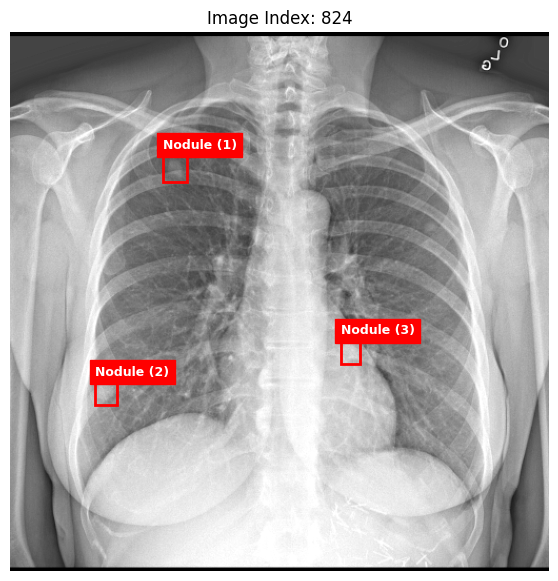

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

idx = 824
image, target = train_det_dataset[idx]

# Debugging del contingut
print("Tipus image:", type(image))
print("Shape image:", image.shape)          # [3, H, W]
print("\nTarget keys:", target.keys())
print("Labels:", target["labels"])          
print("Boxes:", target["boxes"])            

# Preparació de la imatge: Agafem el primer canal i passem a numpy
# image[0] selecciona el primer canal [H, W]
img_np = image[0].cpu().numpy() 

# Crear la figura
fig, ax = plt.subplots(1, figsize=(7, 7))
ax.imshow(img_np, cmap="gray")
ax.set_title(f"Image Index: {idx}") # O X_train[idx] si tens la llista d'IDs a mà
ax.axis("off")

boxes = target["boxes"]
labels = target["labels"]

# Iterem utilitzant el rang per poder accedir a 'labels' correctament
for i in range(len(boxes)):
    x1, y1, x2, y2 = boxes[i].tolist()
    w = x2 - x1
    h = y2 - y1

    # Dibuixar el rectangle
    rect = patches.Rectangle(
        (x1, y1),
        w,
        h,
        linewidth=2,
        edgecolor="red",
        facecolor="none"
    )
    ax.add_patch(rect)

    # Afegir l'etiqueta amb el valor de la label (labels[i].item())
    ax.text(
        x1,
        y1 - 5,
        f"Nodule ({i+1})",
        color="white",
        fontsize=9,
        fontweight='bold',
        backgroundcolor="red" # El vermell destaca millor sobre el gris
    )

plt.show()

In [127]:
import Node21_Utils as Utils
import Node21_Models as Models
import importlib

importlib.reload(Utils)
importlib.reload(Models)

<module 'Node21_Models' from 'C:\\Users\\pauan\\Documentos\\Universidad\\Quart\\1er Quatrimestre\\Aprenentatge Automàtic\\Node21_AA_2025-26\\Node21_Models.py'>

## Entrenament del Model 1 de Detecció: RetinaNetDetector


In [143]:
# Fase 1: Entrenament 'agressiu' només amb imatges positives (amb nòduls)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = Models.RetinaNetDetector().to(device)

optimizer = Utils.make_optimizer_detection(model, lr=1e-2,momentum=0.9, weight_decay=5e-4)

print("Iniciant FASE 1: Entrenament 'agressiu' només amb imatges positives (amb nòduls)...")
history = Utils.fit_det(
    model=model,
    train_loader=train_pos_loader,
    val_loader=val_det_loader,
    optimizer=optimizer,
    epochs=5,
    device=device
)

torch.save(model.state_dict(), "retinanet_phase1.pth")

cpu
Iniciant FASE 1: Entrenament 'agressiu' només amb imatges positives (amb nòduls)...


Èpoques:  20%|██        | 1/5 [08:06<32:24, 486.14s/it]

[Època 1] Train loss 1.8456 (classification:1.1147 | bbox_regression:0.7309)  ||  Val loss 0.5162 (classification:0.3476 | bbox_regression:0.1686)


Èpoques:  40%|████      | 2/5 [16:25<24:40, 493.64s/it]

[Època 2] Train loss 1.6952 (classification:1.0411 | bbox_regression:0.6541)  ||  Val loss 0.5004 (classification:0.3286 | bbox_regression:0.1718)


Èpoques:  60%|██████    | 3/5 [24:43<16:31, 495.68s/it]

[Època 3] Train loss 1.6109 (classification:0.9875 | bbox_regression:0.6235)  ||  Val loss 0.4602 (classification:0.3014 | bbox_regression:0.1588)


Èpoques:  80%|████████  | 4/5 [32:58<08:15, 495.39s/it]

[Època 4] Train loss 1.5473 (classification:0.9599 | bbox_regression:0.5874)  ||  Val loss 0.4524 (classification:0.2943 | bbox_regression:0.1581)


Èpoques: 100%|██████████| 5/5 [41:15<00:00, 495.10s/it]

[Època 5] Train loss 1.3752 (classification:0.8219 | bbox_regression:0.5533)  ||  Val loss 0.4071 (classification:0.2563 | bbox_regression:0.1508)


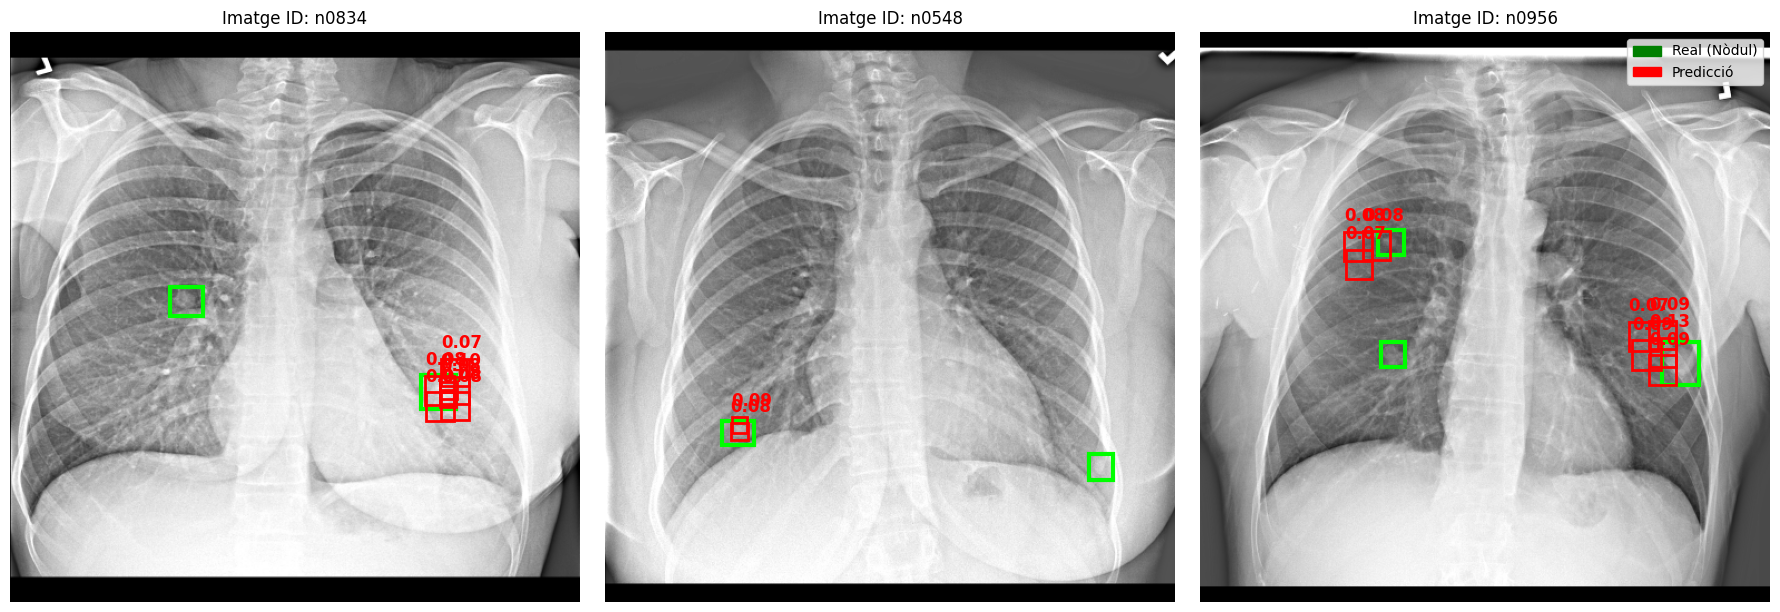

In [147]:
Utils.visualize_positive_predictions(model, val_det_dataset, device, num_images=3, threshold=0.07)

In [145]:
# Fase 2: Refinament amb imatges positives i negatives (mix equilibrat)

optimizer = Utils.make_optimizer_detection(model, lr=1e-3,momentum=0.9, weight_decay=5e-4)

print("\nIniciant FASE 2: Refinament amb imatges sanes i malaltes...")
history2 = Utils.fit_det(
    model=model,
    train_loader=train_mix_loader,
    val_loader=val_det_loader,
    optimizer=optimizer,
    epochs=5,
    device=device
)

torch.save(model.state_dict(), "retinanet_phase2.pth")


Iniciant FASE 2: Refinament amb imatges sanes i malaltes...


Èpoques:  20%|██        | 1/5 [13:25<53:41, 805.40s/it]

[Època 1] Train loss 0.6649 (classification:0.4150 | bbox_regression:0.2499)  ||  Val loss 0.4090 (classification:0.2580 | bbox_regression:0.1510)


Èpoques:  40%|████      | 2/5 [26:50<40:14, 804.94s/it]

[Època 2] Train loss 0.5860 (classification:0.3627 | bbox_regression:0.2234)  ||  Val loss 0.3898 (classification:0.2425 | bbox_regression:0.1473)


Èpoques:  60%|██████    | 3/5 [40:10<26:46, 803.09s/it]

[Època 3] Train loss 0.5376 (classification:0.3309 | bbox_regression:0.2067)  ||  Val loss 0.3820 (classification:0.2336 | bbox_regression:0.1484)


Èpoques:  80%|████████  | 4/5 [53:33<13:22, 802.71s/it]

[Època 4] Train loss 0.4996 (classification:0.3075 | bbox_regression:0.1921)  ||  Val loss 0.3832 (classification:0.2343 | bbox_regression:0.1489)


Èpoques: 100%|██████████| 5/5 [1:06:52<00:00, 802.52s/it]

[Època 5] Train loss 0.4630 (classification:0.2817 | bbox_regression:0.1813)  ||  Val loss 0.3875 (classification:0.2376 | bbox_regression:0.1499)


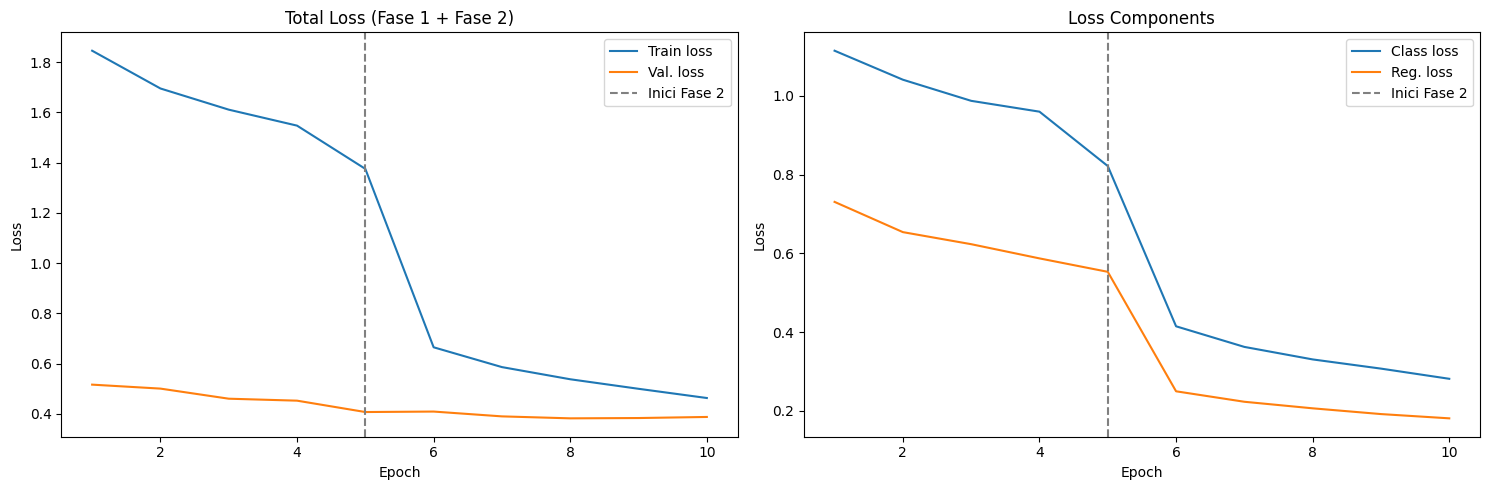

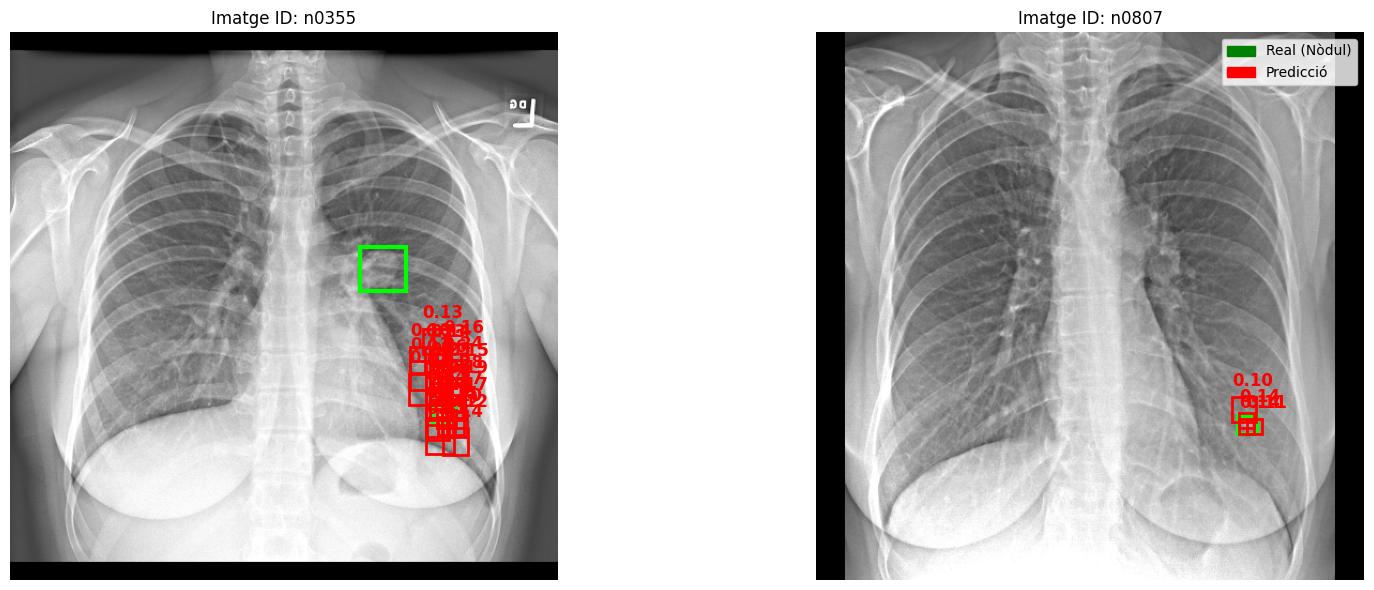

In [163]:
Utils.plot_combined_history(history, history2)
Utils.visualize_positive_predictions(model, val_det_dataset, device, num_images=2, threshold=0.10)


## Entrenament del Model 2 de Detecció: SSD300VGG16Detector

In [12]:
# Fase 1: Entrenament 'agressiu' només amb imatges positives (amb nòduls)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = Models.SSD300VGG16Detector().to(device)

optimizer = Utils.make_optimizer_detection(model, lr=1e-3,momentum=0.9, weight_decay=5e-4)

print("Iniciant FASE 1: Entrenament 'agressiu' només amb imatges positives (amb nòduls)...")
history = Utils.fit_det(
    model=model,
    train_loader=train_pos_loader,
    val_loader=val_det_loader,
    optimizer=optimizer,
    epochs=3,
    device=device
)

torch.save(model.state_dict(), "ssdvgg16_phase1.pth")

cpu
Iniciant FASE 1: Entrenament 'agressiu' només amb imatges positives (amb nòduls)...


Èpoques:  33%|███▎      | 1/3 [03:38<07:17, 218.84s/it]

[Època 1] Train loss 6.8724 (bbox_regression:2.8004 | classification:4.0720)  ||  Val loss 4.1582 (bbox_regression:1.8983 | classification:2.2599)


Èpoques:  67%|██████▋   | 2/3 [07:24<03:42, 222.88s/it]

[Època 2] Train loss 4.3947 (bbox_regression:1.8336 | classification:2.5611)  ||  Val loss 3.3499 (bbox_regression:1.3188 | classification:2.0311)


Èpoques: 100%|██████████| 3/3 [10:57<00:00, 219.02s/it]

[Època 3] Train loss 3.8026 (bbox_regression:1.4233 | classification:2.3794)  ||  Val loss 3.1099 (bbox_regression:1.1355 | classification:1.9744)


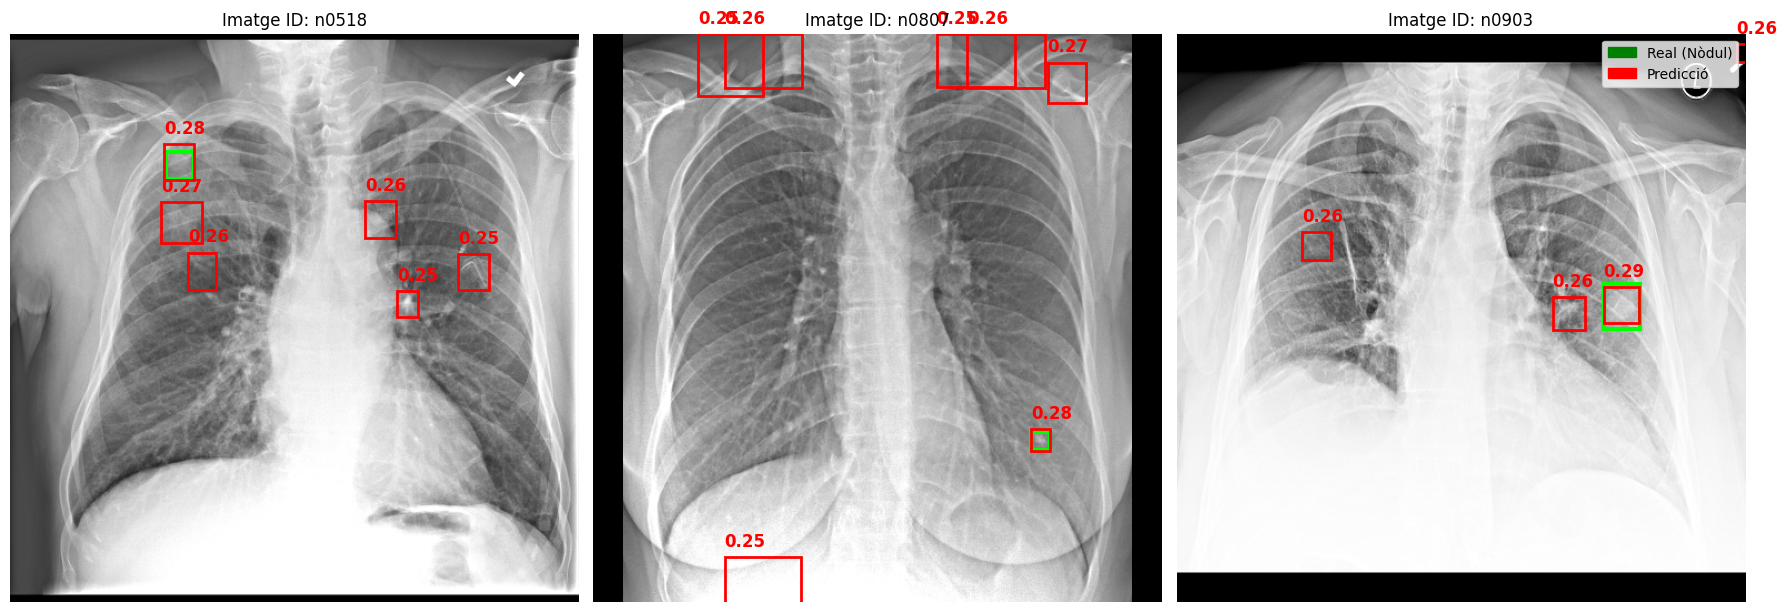

In [16]:
Utils.visualize_positive_predictions(model, val_det_dataset, device, num_images=3, threshold=0.25)

In [15]:
# Fase 2: Refinament amb imatges positives i negatives (mix equilibrat)

optimizer = Utils.make_optimizer_detection(model, lr=5e-4,momentum=0.9, weight_decay=5e-4)

print("\nIniciant FASE 2: Refinament amb imatges sanes i malaltes...")
history2 = Utils.fit_det(
    model=model,
    train_loader=train_mix_loader,
    val_loader=val_det_loader,
    optimizer=optimizer,
    epochs=3,
    device=device
)

torch.save(model.state_dict(), "ssdvgg16_phase2.pth")


Iniciant FASE 2: Refinament amb imatges sanes i malaltes...


Èpoques:  33%|███▎      | 1/3 [05:47<11:35, 347.66s/it]

[Època 1] Train loss 3.4344 (bbox_regression:1.1045 | classification:2.3299)  ||  Val loss 3.0317 (bbox_regression:1.0655 | classification:1.9662)


Èpoques:  67%|██████▋   | 2/3 [11:27<05:43, 343.21s/it]

[Època 2] Train loss 3.1155 (bbox_regression:0.8235 | classification:2.2920)  ||  Val loss 2.9840 (bbox_regression:1.0300 | classification:1.9540)


Èpoques: 100%|██████████| 3/3 [17:11<00:00, 343.76s/it]

[Època 3] Train loss 2.8907 (bbox_regression:0.6223 | classification:2.2684)  ||  Val loss 2.9803 (bbox_regression:1.0343 | classification:1.9460)


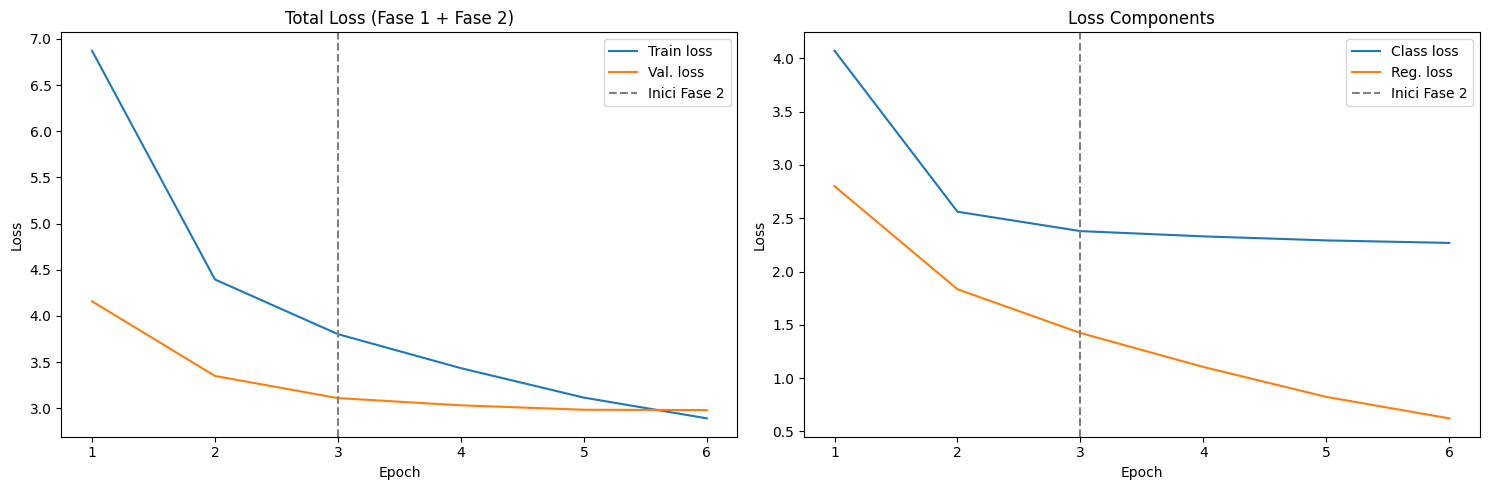

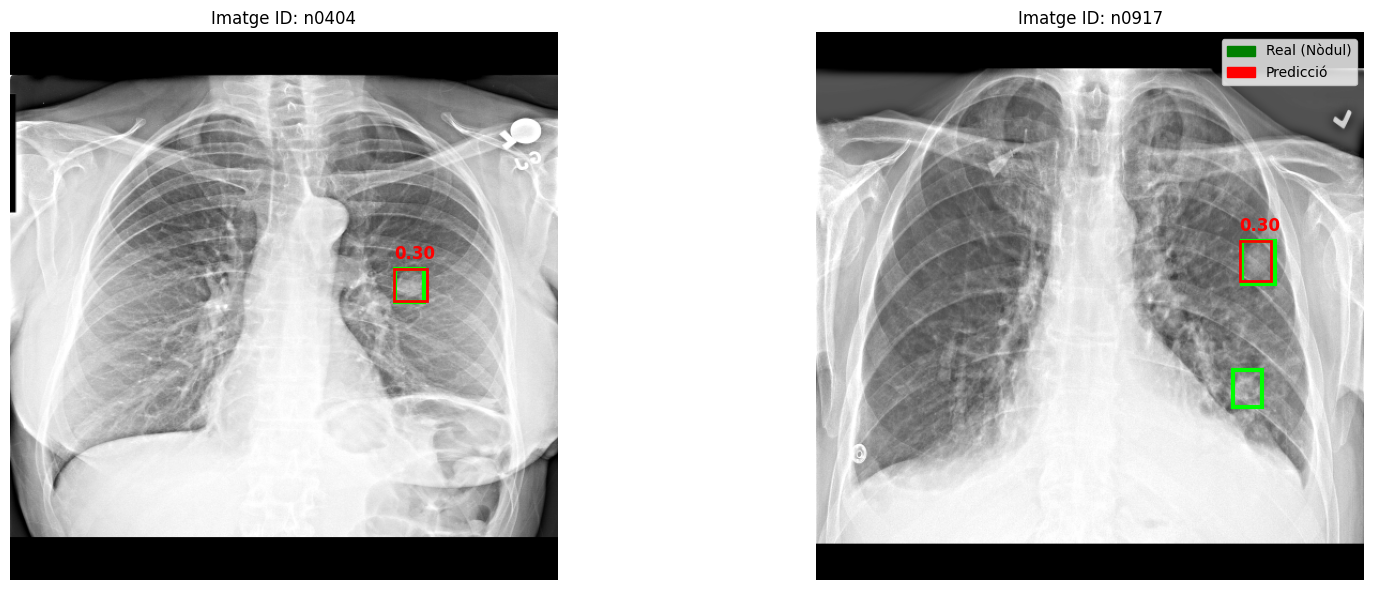

In [116]:
Utils.plot_combined_history(history, history2)
Utils.visualize_positive_predictions(model, val_det_dataset, device, num_images=2, threshold=0.29)

### Model 1

#### Model de detecció `RetinaNet + ResNet50-FPN V2` amb optimització d’àncores per a detecció de nòduls (CXR)

- **Entrada**: radiografies de tòrax en escala de grisos, convertides a **3 canals** i forçades a una mida fixa de **[3, 512, 512]**.
- **Sortida**: detecció d’objectes, amb:
  - caixes delimitadores (*bounding boxes*) de nòduls,
  - etiqueta de classe (**background** o **nòdul**),
  - puntuació de confiança (*score*).
- **Idea general**: model de **detecció d’objectes d’una sola etapa** basat en **RetinaNet**, amb backbone **ResNet50 i Feature Pyramid Network (FPN)**, adaptat mitjançant una **reconfiguració avançada del sistema d’àncores** per detectar nòduls pulmonars de mida petita i mitjana en radiografies de tòrax.


A diferència dels models clàssics de classificació, l’objectiu no és només determinar la presència d’un nòdul, sinó **localitzar explícitament la regió exacta de la imatge on apareix**, ajustant una caixa delimitadora a la seva morfologia real.


El model utilitzat és **RetinaNet amb backbone ResNet50-FPN V2**, una versió millorada que introdueix optimitzacions en l’arquitectura de la **Feature Pyramid Network**, permetent una millor fusió d’informació multi-escala. RetinaNet és un detector de tipus *one-shot*, capaç de realitzar la detecció en una sola passada per la xarxa, fet que el fa eficient i especialment adequat per a objectes petits.


Un dels elements clau de RetinaNet és l’ús de la **Focal Loss**, dissenyada per combatre el fort desequilibri entre fons i objectes d’interès. Aquesta funció de pèrdua penalitza menys els exemples fàcils (background) i prioritza els exemples difícils, fet especialment rellevant en radiografies de tòrax, on els nòduls solen ser subtils i envoltats d’estructures anatòmiques complexes.


El backbone **ResNet50** s’utilitza amb **pesos preentrenats en ImageNet**, la qual cosa permet reutilitzar característiques visuals de baix i mitjà nivell, com textures, vores i patrons estructurals. Per adaptar el model al domini mèdic, s’ha fixat la mida d’entrada a **512×512 píxels**, evitant reescalats interns que podrien degradar la definició dels nòduls més petits.


La innovació principal d’aquesta implementació rau en la **redefinició completa del sistema d’àncores** (*anchors*). Les àncores per defecte de RetinaNet estan optimitzades per a objectes grans, però els nòduls pulmonars solen ser petits i de baixa contrastabilitat. Per aquest motiu, s’ha implementat un **AnchorGenerator multi-escala personalitzat** amb les següents característiques:

- **Mides base d’àncores**:  
  - (8, 16, 32, 64, 128) píxels, significativament més petites que les estàndard.
- **Escales intermèdies**:
  - per a cada mida base s’utilitzen les escales (1.0, 1.26, 1.58), permetent una cobertura més fina de mides possibles.
- **Ratios d’aspecte**:
  - (0.5, 1.0, 2.0), per cobrir diferents morfologies dels nòduls.

Aquesta configuració genera **9 àncores per cada localització** del mapa de característiques, incrementant la probabilitat que alguna àncora s’ajusti bé a la mida real del nòdul.


Com a conseqüència d’aquesta redefinició del sistema d’àncores, ha estat necessari **reconstruir els capçals de sortida** del model. S’han substituït tant la **Classification Head** com la **Regression Head** originals per unes de noves, compatibles amb:
- el nou nombre d’àncores per localització,
- el nombre de classes del problema (**2 classes: background i nòdul**).


L’entrenament del model s’ha realitzat en **dues fases diferenciades**, amb una estratègia progressiva:

- **Fase de localització**:
  - entrenament utilitzant només imatges positives,
  - objectiu: activar la capacitat del model de detectar i localitzar nòduls.
- **Fase de refinament**:
  - entrenament amb un conjunt equilibrat (**50% positives / 50% negatives**),
  - *learning rate* reduït (**1·10⁻⁴**),
  - objectiu: millorar la discriminació entre nòduls reals i estructures anatòmiques com costelles o vasos, reduint els falsos positius.


En conjunt, aquest model permet abordar el problema de manera molt més completa que la classificació binària, ja que no només indica la presència d’un nòdul, sinó que **localitza la seva posició i estima la seva mida dins la radiografia**.

L’ús de **RetinaNet amb ResNet50-FPN V2 i optimització específica d’àncores** ofereix un rendiment superior en la detecció de lesions petites i subtils, convertint aquest model en una eina **robusta i avançada** dins del treball de diagnosi assistida en imatges de RX de tòrax.


### Model 2

#### Model de detecció `SSD300 + VGG16` amb transfer learning per a detecció de nòduls (CXR)

- **Entrada**: radiografies de tòrax en escala de grisos, convertides a **3 canals** i amb forma **[3, H, W]**.
- **Sortida**: detecció d’objectes, amb:
  - caixes delimitadores (*bounding boxes*) de nòduls,
  - etiqueta de classe (**background** o **nòdul**).
- **Idea general**: model de **detecció d’objectes** basat en **SSD (Single Shot Detector)** amb un backbone **VGG16 preentrenat**, adaptat mitjançant transfer learning per detectar nòduls pulmonars en radiografies.


Aquest model suposa un canvi respecte als models anteriors de classificació. En lloc de decidir únicament si una imatge conté o no un nòdul, l’objectiu és **localitzar explícitament la regió de la imatge on apareix el nòdul**, mitjançant una caixa delimitadora, a més d’assignar-li una classe.


El model utilitzat és **SSD300 amb backbone VGG16**, una arquitectura clàssica i àmpliament validada per a detecció d’objectes. SSD és un detector de tipus *single-shot*, és a dir, realitza la detecció en una sola passada per la xarxa, sense etapes separades de proposta de regions. Això el fa més simple i eficient que altres enfocaments de dues etapes.


El backbone **VGG16** està **preentrenat en ImageNet**, fet que permet reutilitzar característiques visuals bàsiques com vores, textures i patrons de forma. Aquest ús de **transfer learning** és especialment avantatjós en contextos mèdics, on el nombre d’imatges anotades amb caixes delimitadores sol ser limitat i costós d’obtenir.


El model preentrenat espera **imatges de 3 canals**, ja que ha estat entrenat amb imatges RGB. Com que les radiografies són en escala de grisos, les imatges es converteixen de **[1, H, W] a [3, H, W]** repetint el canal. Aquesta estratègia permet reutilitzar directament els pesos preentrenats sense modificar les capes convolucionals inicials del backbone.

En aquesta implementació **no es redefineix el model des de zero**, sinó que s’utilitza directament l’arquitectura `ssd300_vgg16` proporcionada per `torchvision`. La principal modificació realitzada és l’adaptació del **capçal de classificació** del detector.


Concretament, s’ha substituït la **classification head** original del model per una nova capçalera compatible amb el problema plantejat. SSD utilitza múltiples mapes de característiques a diferents escales, i per a cada nivell prediu:

- les coordenades de les caixes delimitadores,
- la classe associada a cada àncora (*anchor*).

En aquest cas, el nombre de classes s’ha ajustat a **2 classes**:
- `0`: background,
- `1`: nòdul.


Per mantenir la coherència amb l’arquitectura original, s’han reutilitzat:
- els **canals d’entrada** de cada nivell de feature maps,
- el **nombre d’àncores per localització** definit per l’anchor generator original.

A partir d’això, es construeix una nova `SSDClassificationHead` amb el nombre de classes adequat al problema de detecció de nòduls, sense alterar l’estructura interna del detector.


El mètode `forward` del model segueix l’API estàndard de detecció de `torchvision`:

- durant l’entrenament, rep:
  - una llista d’imatges,
  - una llista de diccionaris amb les caixes (`boxes`) i les etiquetes (`labels`);
- durant la inferència, retorna:
  - les caixes detectades,
  - les puntuacions (*scores*),
  - i les classes predites.


En conjunt, aquest model permet abordar el problema de manera més completa que la classificació binària, ja que no només indica la presència d’un nòdul, sinó que també **localitza la seva posició dins la radiografia**.

L’ús de **transfer learning amb SSD300 + VGG16** ofereix un bon compromís entre capacitat del model, estabilitat d’entrenament i disponibilitat de pesos preentrenats, fent-lo una elecció adequada per a una pràctica de detecció de nòduls en imatges de RX de tòrax.




## Innovació